# Load Thumos 2014 I3D features

In [3]:
import numpy as np
import glob
import utils.utils as util
import time
import os

class Dataset():
    def __init__(self, args):
        self.trainidx = []
        self.dataset_name = args.dataset_name
        self.path_to_annotations = os.path.join(args.annotation_path, args.dataset_name + '-Annotations/')
        self.path_to_features = os.path.join(args.I3D_path, self.dataset_name + '-I3D-JOINTFeatures.npy')
        self.labels = np.load(self.path_to_annotations + 'labels_all.npy')     # Specific to Thumos14
        self.classlist = np.load(self.path_to_annotations + 'classlist.npy')
        self.subset = np.load(self.path_to_annotations + 'subset.npy')
        self.testidx = []
        self.classwiseidx = []
        self.train_test_idx()
        self.currenttestidx = 0
        self.t_max = args.max_seqlen
        self.num_class = args.num_class
        self.classwise_feature_mapping()
        self.batch_size = args.batch_size
        self.feature_size = args.feature_size
        self.features = np.load(self.path_to_features, encoding='bytes')
        self.segments = np.load(self.path_to_annotations + 'segments.npy')
        self.labels_multihot = [util.strlist2multihot(labs,self.classlist) for labs in self.labels]


    def train_test_idx(self):
        for i, s in enumerate(self.subset):
            if s.decode('utf-8') == 'validation':   # Specific to Thumos14
                self.trainidx.append(i)
            else:
                self.testidx.append(i)

    def classwise_feature_mapping(self):
        for category in self.classlist:
            idx = []
            for i in self.trainidx:
                for label in self.labels[i]:
                    if label == category.decode('utf-8'):
                        idx.append(i); break;
            self.classwiseidx.append(idx)


    def load_data(self, n_similar=3, is_training=True):
        if is_training==True:
            features = []
            labels = []
            idx = []

            # Load similar pairs
            rand_classid = np.random.choice(len(self.classwiseidx), size=n_similar)
            for rid in rand_classid:
                rand_sampleid = np.random.choice(len(self.classwiseidx[rid]), size=2)
                idx.append(self.classwiseidx[rid][rand_sampleid[0]])
                idx.append(self.classwiseidx[rid][rand_sampleid[1]])

            # Load rest pairs
            rand_sampleid = np.random.choice(len(self.trainidx), size=self.batch_size-2*n_similar)
            for r in rand_sampleid:
                idx.append(self.trainidx[r])
          
            return np.array([util.process_feat(self.features[i], self.t_max) for i in idx]), np.array([self.labels_multihot[i] for i in idx])

        else:
            labs = self.labels_multihot[self.testidx[self.currenttestidx]]
            feat = self.features[self.testidx[self.currenttestidx]]

            if self.currenttestidx == len(self.testidx)-1:
                done = True; self.currenttestidx = 0
            else:
                done = False; self.currenttestidx += 1
         
            return np.array(feat), np.array(labs), done


In [4]:
import utils.options
import torch
import torch.nn as nn

class Args():
    def __init__(self):
        self.lr = 0.0001
        self.dataset_name = 'Thumos14reduced'
        self.num_class = 20
        self.feature_size = 2048
        self.batch_size = 24
        self.max_seqlen = 750
        self.model_name = 'weakloc'
        self.pretrained_ckpt = None
        self.max_iter = 50000
        self.num_similar = 3
        self.checkpoint_path = './checkpoint/'
        self.annotation_path = './annotations/'
        self.I3D_path = './I3D_features/'

args = Args()

# Load the dataset
thomoas_i3d_dataset = Dataset(args)

In [279]:
# Test Thumas Dataset

# Randomly extract 10 video clips' I3D feature
features, labels = thomoas_i3d_dataset.load_data(n_similar=args.num_similar, is_training=True)

# Features are alingned in 750 frames all the same, now trunk it into actual max length
seq_len = np.sum(np.max(np.abs(features), axis=2) > 0, axis=1)
features = features[:,:np.max(seq_len),:]

# Convert to CUDA tensor
features = torch.from_numpy(features).float().to('cuda')
labels = torch.from_numpy(labels).float().to('cuda')

# Temporal Pooling Module

In [364]:
# Attention Module
# Test

class Attention_Module(nn.Module):
    """Args:
    feature_dim: dimension of the feature from I3D model.
    """

    def __init__(self, feature_dim):
        super(Attention_Module, self).__init__()
        
        self.feature_dim = feature_dim
        self.fc0 = nn.Linear(feature_dim, 1024)
        self.fc1 = nn.Linear(1024, 256)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        self.fc3 = nn.Linear(2048, 20)

    def forward(self, features_list):
        """Build the attention module.

        Args:
        features_list: (batch_size, num_frame, feat_depth)

        Returns:
        The attention weights, weigted features
        """
        
        attention_weights = []
        weighted_features = []
        
        # Iterate through batch
        for idx, video_features in enumerate(features_list):
                        
            # Trunk feature into real length
            seq_len = (torch.abs(video_features).max(dim=1)[0] > 0).sum().tolist()
            video_features = video_features[: seq_len, :]
            
            # Iterate through video segments
            output = self.sigmoid(self.fc2(self.relu(self.fc1(self.relu(self.fc0(video_features))))))

            # Temporal Pool
            weighted_pooling = (output*video_features).sum(0)/video_features.shape[0]
            
            # Save weights/features
            output = output.reshape(output.shape[0])
            attention_weights.append(output)
            weighted_features.append(weighted_pooling)
            
        # Reshape to tensor
        weighted_features = torch.stack(weighted_features)
#         attention_weights = torch.stack(attention_weights)
        
        predict = self.sigmoid(self.fc3(weighted_features))
        
        return attention_weights, weighted_features, predict


def l1_norm(inputs):
    norm_value = torch.zeros(len(inputs)).cuda()
    for idx, vector in enumerate(inputs):
        norm_value[idx] = torch.norm(torch.abs(vector), p=1)
    return norm_value.sum()


def multi_to_single(labels):
    l = []
    for lab in labels:
        l.append(lab.tolist().index(1))
    return torch.from_numpy(np.asarray(l)).cuda()

# Attention Module
# Test

# class Attention_Module(nn.Module):
#     """Args:
#     feature_dim: dimension of the feature from I3D model.
#     """

#     def __init__(self, feature_dim):
#         super(Attention_Module, self).__init__()
        
#         self.feature_dim = feature_dim
#         self.fc1 = nn.Linear(2048, 256)
#         self.relu = nn.ReLU(inplace=True)
#         self.fc2 = nn.Linear(256, 20)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, features_list):
#         """Build the attention module.

#         Args:
#         features_list: (batch_size, num_frame, feat_depth)

#         Returns:
#         The attention weights, weigted features
#         """
        
#         weighted_features = []
        
#         # Iterate through batch
#         for idx, video_features in enumerate(features_list):
                        
#             # Trunk feature into real length
#             seq_len = (torch.abs(video_features).max(dim=1)[0] > 0).sum().tolist()
#             video_features = video_features[: seq_len, :]
            

#             # Temporal Pool
#             weighted_pooling = video_features.sum(0)/video_features.shape[0]
            
#             # Save weights/features
#             weighted_features.append(weighted_pooling)
            
#         # Reshape to tensor
#         weighted_features = torch.stack(weighted_features)
        
#         predict = self.sigmoid((self.fc2(self.relu(self.fc1(weighted_features)))))
        
#         return _, _, predict



In [373]:
# Attention Module Testing
model = Attention_Module(feature_dim=2048)
model.cuda()
print('Attention Model loaded')

# Optimizer
lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Softmax Loss Define
softmax_loss = nn.BCELoss()
# margin_loss = nn.MultiLabelSoftMarginLoss()
# cross_loss = nn.CrossEntropyLoss() 

Attention Model loaded


# Training

Epoch:000, Loss: 0.7365882992744446
[0.48892903327941895, 0.4875156581401825, 0.48839637637138367, 0.48864591121673584, 0.4883250594139099, 0.48798906803131104, 0.4926201105117798, 0.4906476140022278, 0.5043951869010925, 0.4976559281349182]


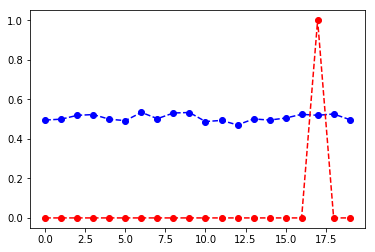

Epoch:100, Loss: 0.27002930641174316
[0.6984211802482605, 0.7242940068244934, 0.7270314693450928, 0.7223972678184509, 0.721885621547699, 0.7140164375305176, 0.712637186050415, 0.6717967391014099, 0.6534277200698853, 0.6805679202079773]


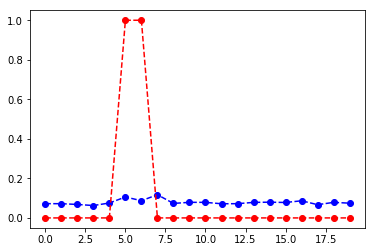

Epoch:200, Loss: 0.248797208070755
[0.6126003265380859, 0.6033896803855896, 0.6106059551239014, 0.6135592460632324, 0.6095141172409058, 0.6122049689292908, 0.615994393825531, 0.6657465696334839, 0.6680095195770264, 0.6718054413795471]


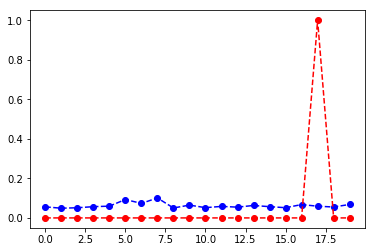

Epoch:300, Loss: 0.2599716782569885
[0.5877969861030579, 0.5926019549369812, 0.6044957637786865, 0.6153818964958191, 0.6087346076965332, 0.6049095988273621, 0.6014907956123352, 0.6081585884094238, 0.612048327922821, 0.6196030974388123]


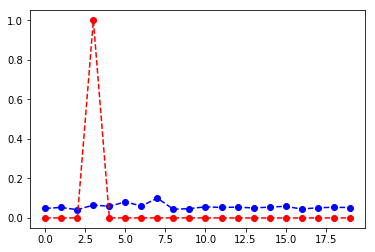

Epoch:400, Loss: 0.24187780916690826
[0.5628452301025391, 0.565009593963623, 0.5648329854011536, 0.5675245523452759, 0.5673516392707825, 0.5667327046394348, 0.5677192211151123, 0.5779933333396912, 0.5807328820228577, 0.5802874565124512]


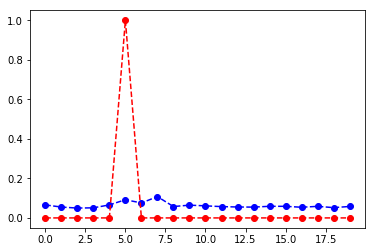

Epoch:500, Loss: 0.2320071905851364
[0.5703238844871521, 0.5708004832267761, 0.5704920291900635, 0.5682834386825562, 0.5678589940071106, 0.5704122185707092, 0.5686919689178467, 0.5653094053268433, 0.5706832408905029, 0.5704987645149231]


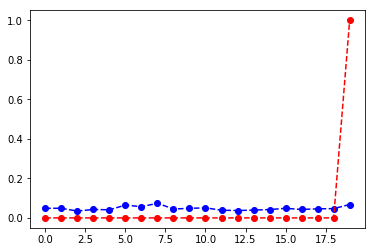

Epoch:600, Loss: 0.23104265332221985
[0.5439456105232239, 0.5438833832740784, 0.5420647859573364, 0.5460492968559265, 0.5455198884010315, 0.5466271638870239, 0.5472059845924377, 0.5486705303192139, 0.5536505579948425, 0.5566244721412659]


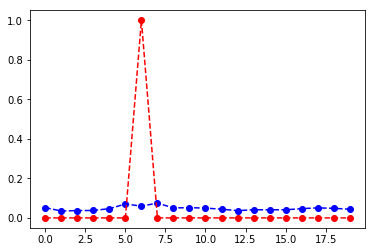

Epoch:700, Loss: 0.23167537152767181
[0.5533096194267273, 0.5616070032119751, 0.550971508026123, 0.5499509572982788, 0.5581868886947632, 0.5517581105232239, 0.545434296131134, 0.5480445027351379, 0.5367603302001953, 0.537452757358551]


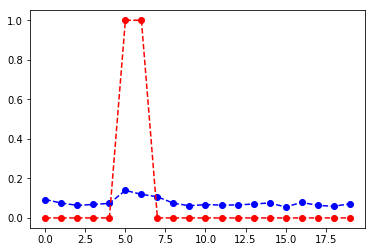

Epoch:800, Loss: 0.21468859910964966
[0.5412282943725586, 0.5422902703285217, 0.5609437823295593, 0.5426400899887085, 0.5454155206680298, 0.5562776923179626, 0.5573442578315735, 0.5609311461448669, 0.573533296585083, 0.5582040548324585]


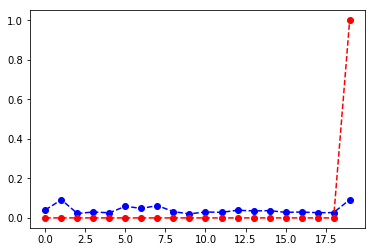

Epoch:900, Loss: 0.2259616255760193
[0.5227948427200317, 0.5253016352653503, 0.525219202041626, 0.526495635509491, 0.5261245965957642, 0.525265634059906, 0.5257394313812256, 0.525141179561615, 0.5278151631355286, 0.5285354256629944]


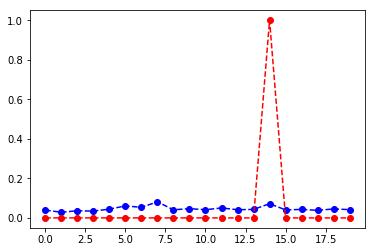

Epoch:1000, Loss: 0.2244901806116104
[0.5264753699302673, 0.5305442214012146, 0.5349037647247314, 0.525174617767334, 0.5289934873580933, 0.5335125923156738, 0.5266767740249634, 0.5290879011154175, 0.5269879102706909, 0.5229784846305847]


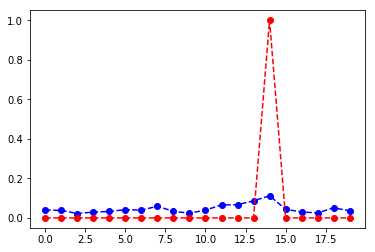

Epoch:1100, Loss: 0.20480850338935852
[0.5473354458808899, 0.548721194267273, 0.5490934252738953, 0.5517190098762512, 0.5531258583068848, 0.5478087067604065, 0.5490477681159973, 0.5494527816772461, 0.5574672818183899, 0.5551108121871948]


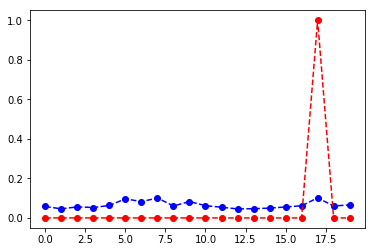

Epoch:1200, Loss: 0.2107042670249939
[0.5255682468414307, 0.528862476348877, 0.5301360487937927, 0.5305076837539673, 0.5548469424247742, 0.555189847946167, 0.5608940720558167, 0.551582932472229, 0.5537455081939697, 0.5621523857116699]


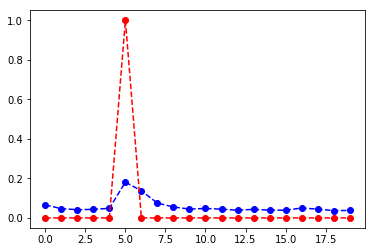

Epoch:1300, Loss: 0.2178172916173935
[0.5358114838600159, 0.533153772354126, 0.5342115759849548, 0.5349677801132202, 0.5344359874725342, 0.5329763889312744, 0.5979740023612976, 0.5886627435684204, 0.5905289649963379, 0.5836017727851868]


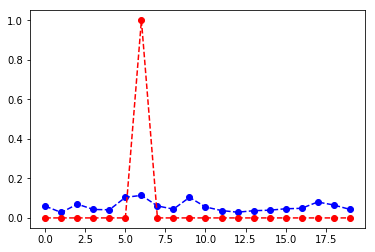

Epoch:1400, Loss: 0.20645122230052948
[0.5620422959327698, 0.5634515285491943, 0.567986011505127, 0.5583363771438599, 0.5661920309066772, 0.5628364086151123, 0.5627569556236267, 0.5595456957817078, 0.560165286064148, 0.5564039349555969]


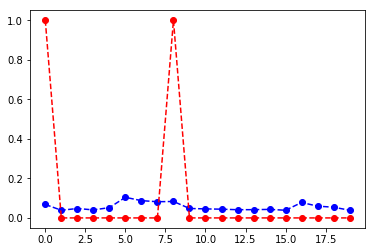

Epoch:1500, Loss: 0.1867125928401947
[0.5736697316169739, 0.5605811476707458, 0.5549228191375732, 0.5417050123214722, 0.5635749101638794, 0.5626627802848816, 0.548798680305481, 0.5482596755027771, 0.5826420783996582, 0.5658307075500488]


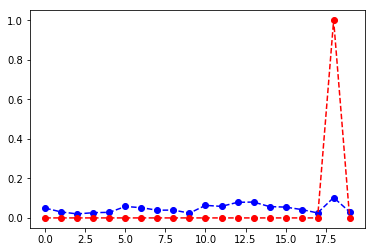

Epoch:1600, Loss: 0.1819762885570526
[0.6132081747055054, 0.6105949878692627, 0.6282522678375244, 0.6191032528877258, 0.619640052318573, 0.6247240900993347, 0.6244012713432312, 0.6248003840446472, 0.6122370958328247, 0.624485433101654]


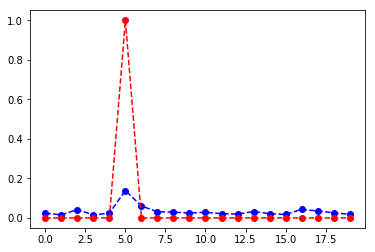

Epoch:1700, Loss: 0.1795322299003601
[0.6809690594673157, 0.7194826006889343, 0.7483611702919006, 0.7408109307289124, 0.7349593043327332, 0.670832097530365, 0.6589357852935791, 0.6589052081108093, 0.6558424234390259, 0.6665008664131165]


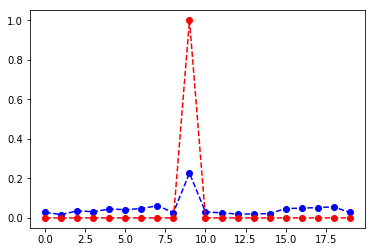

Epoch:1800, Loss: 0.19343404471874237
[0.6776115894317627, 0.7113856673240662, 0.6672968864440918, 0.6667028069496155, 0.6537785530090332, 0.6792320609092712, 0.6309179663658142, 0.6470217704772949, 0.6298729777336121, 0.6584863662719727]


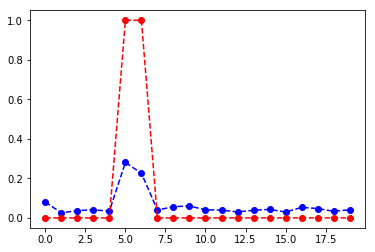

Epoch:1900, Loss: 0.16976195573806763
[0.5843603014945984, 0.5942783951759338, 0.6362298130989075, 0.6378750205039978, 0.6311188340187073, 0.6786339282989502, 0.6675617694854736, 0.6438050866127014, 0.7606217861175537, 0.6348096132278442]


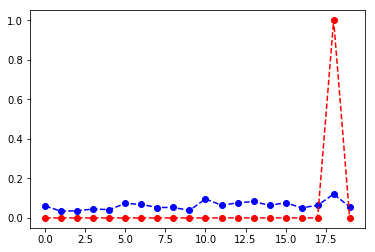

Epoch:2000, Loss: 0.1986854076385498
[0.8231235146522522, 0.6406083106994629, 0.8330045342445374, 0.7810988426208496, 0.7963853478431702, 0.814934492111206, 0.8269312381744385, 0.7925891876220703, 0.7879464030265808, 0.7789872288703918]


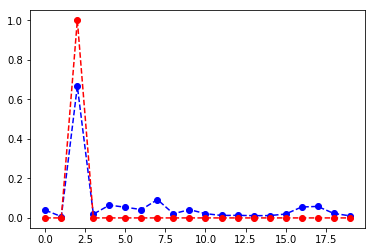

Epoch:2100, Loss: 0.17626532912254333
[0.836943507194519, 0.8111772537231445, 0.6409361362457275, 0.6821853518486023, 0.682060182094574, 0.7043381333351135, 0.7172356247901917, 0.7415382862091064, 0.6748239398002625, 0.699467658996582]


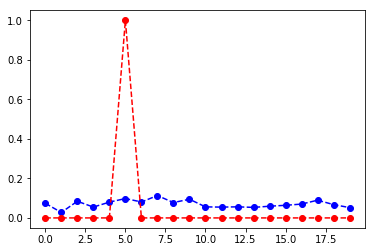

Epoch:2200, Loss: 0.15455150604248047
[0.8782959580421448, 0.8991575837135315, 0.9020493626594543, 0.9195235967636108, 0.9188330173492432, 0.9266507625579834, 0.945214033126831, 0.9288658499717712, 0.9007188081741333, 0.8319587111473083]


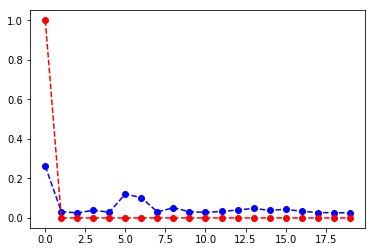

Epoch:2300, Loss: 0.15307791531085968
[0.8363429307937622, 0.8540241718292236, 0.920377254486084, 0.8420624732971191, 0.7800053358078003, 0.8528106212615967, 0.7863170504570007, 0.8551040291786194, 0.8464815616607666, 0.8407402038574219]


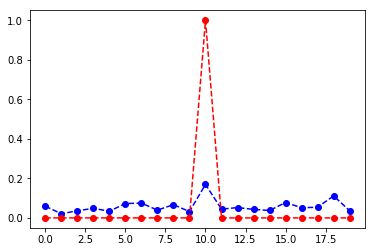

Epoch:2400, Loss: 0.16207510232925415
[0.6044019460678101, 0.636925220489502, 0.6258194446563721, 0.6727794408798218, 0.7166419625282288, 0.7314165830612183, 0.7858783602714539, 0.8337319493293762, 0.8383857607841492, 0.8376431465148926]


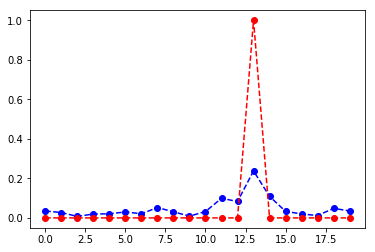

Epoch:2500, Loss: 0.1598682701587677
[0.5138200521469116, 0.5210366249084473, 0.5148755311965942, 0.5181047916412354, 0.5180891752243042, 0.5174890756607056, 0.5178132057189941, 0.5157839059829712, 0.5219632387161255, 0.5231046676635742]


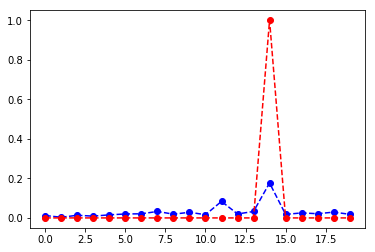

Epoch:2600, Loss: 0.16167783737182617
[0.8816865086555481, 0.8159688115119934, 0.8746179938316345, 0.8034275770187378, 0.8410170078277588, 0.8505212664604187, 0.8238868117332458, 0.7334692478179932, 0.8115535378456116, 0.907257080078125]


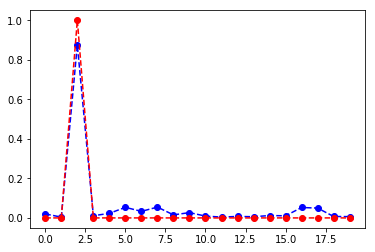

Epoch:2700, Loss: 0.17561110854148865
[0.6421377658843994, 0.5422245264053345, 0.4912009537220001, 0.5000127553939819, 0.4979499280452728, 0.4988127648830414, 0.5071053504943848, 0.4758373498916626, 0.491529643535614, 0.4809187948703766]


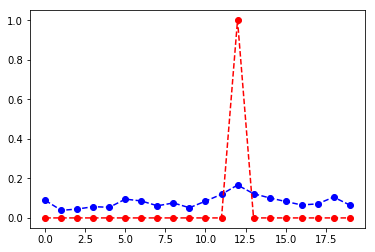

Epoch:2800, Loss: 0.15740618109703064
[0.5632964968681335, 0.5779818892478943, 0.5923834443092346, 0.5561402440071106, 0.513265073299408, 0.5234423875808716, 0.778134822845459, 0.8943828344345093, 0.9101608991622925, 0.9612891674041748]


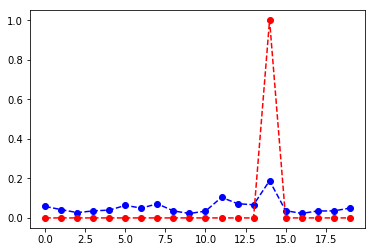

Epoch:2900, Loss: 0.14640475809574127
[0.4419504404067993, 0.4427380859851837, 0.4410492777824402, 0.44090086221694946, 0.44200971722602844, 0.4464530348777771, 0.44451966881752014, 0.4432523846626282, 0.4460412263870239, 0.4479910433292389]


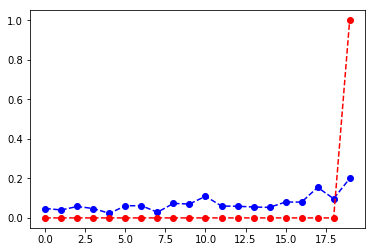

Epoch:3000, Loss: 0.16929171979427338
[0.546427309513092, 0.6303204894065857, 0.6121396422386169, 0.6316574215888977, 0.5906606316566467, 0.6132614016532898, 0.523847222328186, 0.7542557716369629, 0.8115861415863037, 0.8332220315933228]


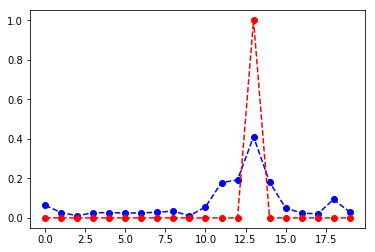

Epoch:3100, Loss: 0.1352720856666565
[0.4360043704509735, 0.5875439643859863, 0.8347067832946777, 0.6292526721954346, 0.7341070771217346, 0.6729871034622192, 0.7338483333587646, 0.7115339636802673, 0.8329704403877258, 0.9162381291389465]


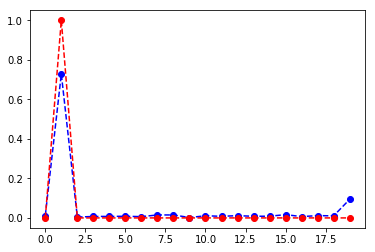

Epoch:3200, Loss: 0.15548500418663025
[0.39071497321128845, 0.38165661692619324, 0.43190592527389526, 0.4288140833377838, 0.4194132387638092, 0.42727625370025635, 0.40989941358566284, 0.6302748918533325, 0.452532559633255, 0.4104199707508087]


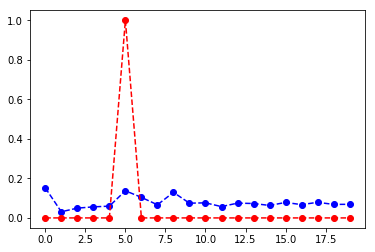

Epoch:3300, Loss: 0.16633258759975433
[0.38317906856536865, 0.5206307768821716, 0.649847686290741, 0.6338533163070679, 0.581015944480896, 0.4251657724380493, 0.40328869223594666, 0.34768733382225037, 0.33379095792770386, 0.33571159839630127]


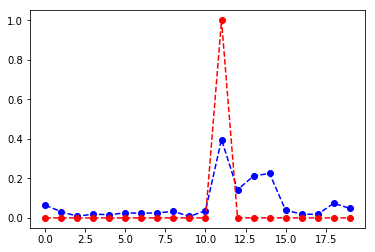

Epoch:3400, Loss: 0.128286674618721
[0.3716087341308594, 0.5449686646461487, 0.4651705324649811, 0.4778590798377991, 0.4872450828552246, 0.9930511713027954, 0.9971283078193665, 0.9897748231887817, 0.984583854675293, 0.979036271572113]


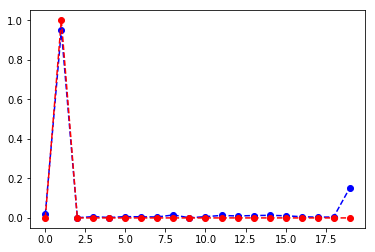

Epoch:3500, Loss: 0.13913483917713165
[0.39628884196281433, 0.33989837765693665, 0.49260327219963074, 0.37297919392585754, 0.3148362636566162, 0.7080615758895874, 0.5279957056045532, 0.7591845393180847, 0.8276712894439697, 0.8660038113594055]


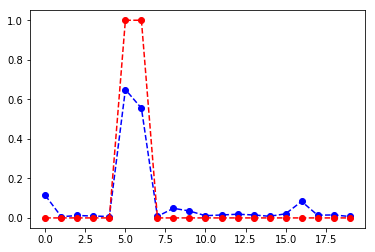

Epoch:3600, Loss: 0.14833582937717438
[0.36010998487472534, 0.3806472420692444, 0.6744531393051147, 0.7188494801521301, 0.47065842151641846, 0.5395638942718506, 0.5605570673942566, 0.6583844423294067, 0.5869528651237488, 0.32541802525520325]


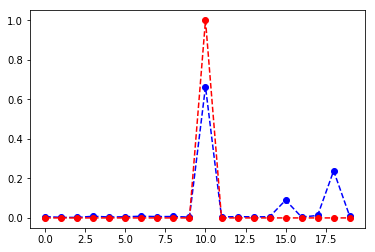

Epoch:3700, Loss: 0.14291058480739594
[0.9844047427177429, 0.9752442240715027, 0.39398038387298584, 0.5258961915969849, 0.5281663537025452, 0.5048248171806335, 0.5508210062980652, 0.7015016674995422, 0.49766620993614197, 0.586732804775238]


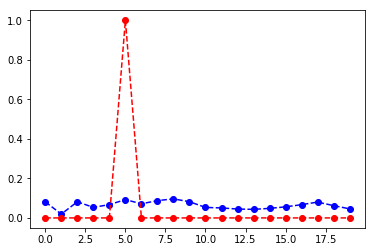

Epoch:3800, Loss: 0.14005520939826965
[0.3367055058479309, 0.385442316532135, 0.9857164025306702, 0.8977392315864563, 0.8189698457717896, 0.8250517249107361, 0.8699617385864258, 0.8632972240447998, 0.9779521822929382, 0.9315968751907349]


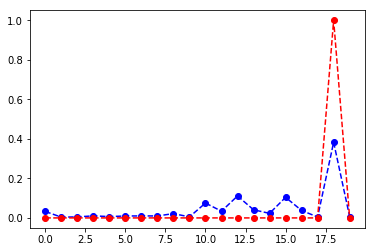

Epoch:3900, Loss: 0.13701042532920837
[0.8836480379104614, 0.6357994079589844, 0.902604341506958, 0.8825015425682068, 0.9926844835281372, 0.9875384569168091, 0.9646889567375183, 0.9894256591796875, 0.9984134435653687, 0.9904505610466003]


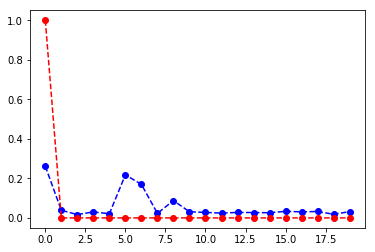

Epoch:4000, Loss: 0.1285366266965866
[0.9159519672393799, 0.9630863070487976, 0.9049468040466309, 0.9410423636436462, 0.7981793284416199, 0.89357990026474, 0.6097885370254517, 0.653392493724823, 0.5750932693481445, 0.7684275507926941]


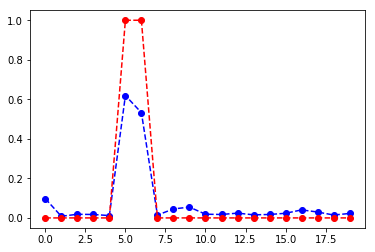

Epoch:4100, Loss: 0.11910557746887207
[0.40655606985092163, 0.546234130859375, 0.5320908427238464, 0.5835049152374268, 0.4937538802623749, 0.5707297325134277, 0.40431904792785645, 0.8059499859809875, 0.8872727751731873, 0.9049453139305115]


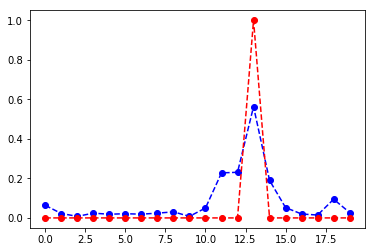

Epoch:4200, Loss: 0.1416485458612442
[0.32045990228652954, 0.47029972076416016, 0.7500134706497192, 0.7184903621673584, 0.5601022243499756, 0.6278164386749268, 0.9856123924255371, 0.9936137795448303, 0.9887397885322571, 0.9974722266197205]


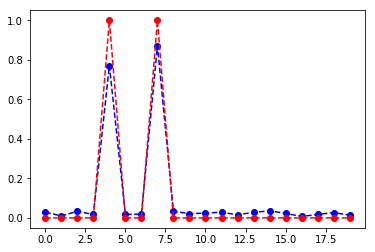

Epoch:4300, Loss: 0.1372814178466797
[0.9591805934906006, 0.9500730037689209, 0.9769017100334167, 0.9206734895706177, 0.527119517326355, 0.5815324783325195, 0.6953031420707703, 0.47693145275115967, 0.42219221591949463, 0.46137556433677673]


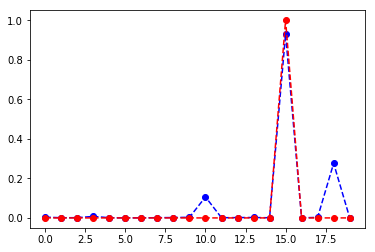

Epoch:4400, Loss: 0.1298120617866516
[0.9901686906814575, 0.44364386796951294, 0.9961813688278198, 0.9475210905075073, 0.9650864601135254, 0.9737802743911743, 0.98058021068573, 0.9500783085823059, 0.9432342052459717, 0.9241394400596619]


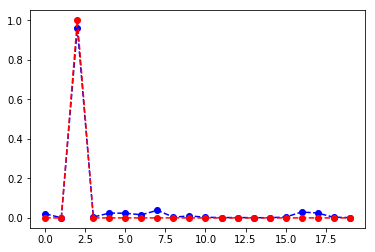

Epoch:4500, Loss: 0.09667149186134338
[0.2193903625011444, 0.22289569675922394, 0.2350103259086609, 0.36485564708709717, 0.21659646928310394, 0.21334804594516754, 0.2559051513671875, 0.19662395119667053, 0.24396228790283203, 0.21278871595859528]


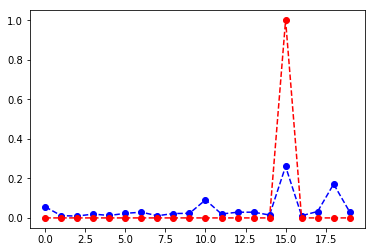

Epoch:4600, Loss: 0.12996996939182281
[0.7607191205024719, 0.3419598639011383, 0.8517460823059082, 0.9767131209373474, 0.9931840300559998, 0.9964228272438049, 0.9750151038169861, 0.9977188110351562, 0.9965142607688904, 0.9988884329795837]


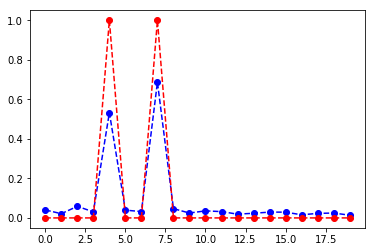

Epoch:4700, Loss: 0.13221418857574463
[0.23503442108631134, 0.23659124970436096, 0.22807875275611877, 0.22219477593898773, 0.5500956177711487, 0.7617926001548767, 0.5547102689743042, 0.8797454833984375, 0.8792489171028137, 0.6228659749031067]


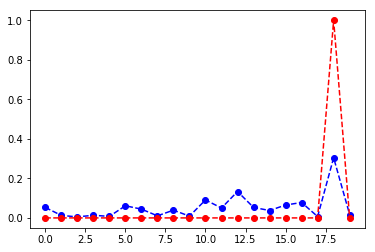

Epoch:4800, Loss: 0.1374952495098114
[0.9749854207038879, 0.9718160033226013, 0.9326392412185669, 0.9756869673728943, 0.9764289855957031, 0.9757975935935974, 0.9991625547409058, 0.9866272807121277, 0.9540004730224609, 0.9055722951889038]


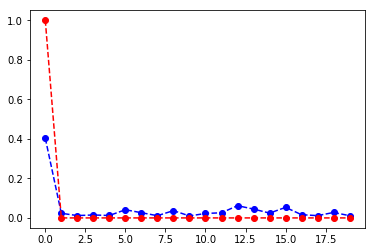

Epoch:4900, Loss: 0.1432286947965622
[0.23647141456604004, 0.22885333001613617, 0.22166183590888977, 0.23813728988170624, 0.23754005134105682, 0.2304876744747162, 0.23814916610717773, 0.23487643897533417, 0.2531050145626068, 0.24996262788772583]


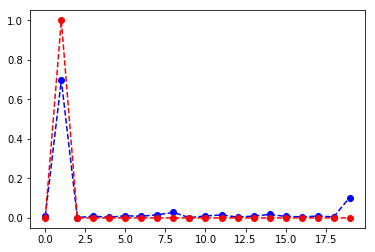

Epoch:5000, Loss: 0.12589877843856812
[0.17678895592689514, 0.1664363145828247, 0.20629872381687164, 0.20383520424365997, 0.19967639446258545, 0.2062695026397705, 0.18656699359416962, 0.6553451418876648, 0.27307209372520447, 0.19519780576229095]


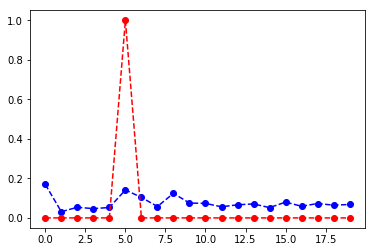

Epoch:5100, Loss: 0.12412425875663757
[0.9057256579399109, 0.9288448691368103, 0.9133166670799255, 0.6887245774269104, 0.6070517897605896, 0.89594966173172, 0.5031479001045227, 0.17796094715595245, 0.18741141259670258, 0.14371290802955627]


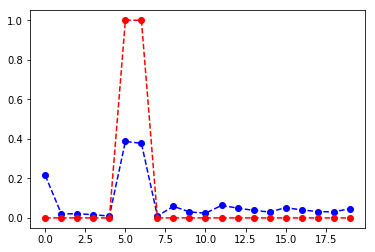

Epoch:5200, Loss: 0.138956218957901
[0.9933187961578369, 0.990321695804596, 0.9994845390319824, 0.9986904263496399, 0.9935459494590759, 0.7507814764976501, 0.9897038340568542, 0.9547252058982849, 0.9987702965736389, 0.9851824641227722]


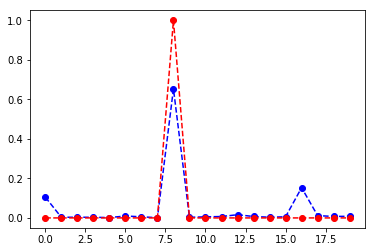

Epoch:5300, Loss: 0.11444950103759766
[0.99379563331604, 0.9910098314285278, 0.9995287656784058, 0.9988316893577576, 0.9942448735237122, 0.7622085809707642, 0.9907797574996948, 0.9581183791160583, 0.9989193677902222, 0.9865022897720337]


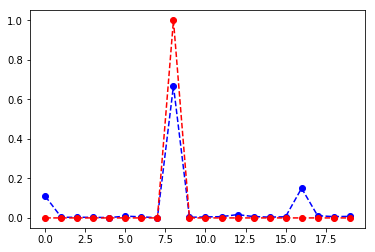

Epoch:5400, Loss: 0.13614225387573242
[0.49301275610923767, 0.33367854356765747, 0.22539037466049194, 0.3293784558773041, 0.19188661873340607, 0.16947823762893677, 0.29599571228027344, 0.2646356225013733, 0.39410534501075745, 0.4138876497745514]


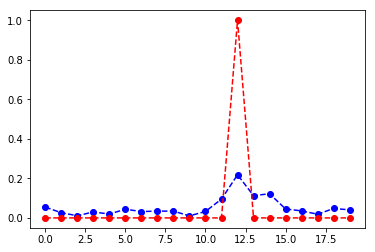

Epoch:5500, Loss: 0.12770472466945648
[0.20525476336479187, 0.20422238111495972, 0.2032344937324524, 0.19849994778633118, 0.20380066335201263, 0.19480255246162415, 0.14920689165592194, 0.7097882032394409, 0.1739291250705719, 0.1573028713464737]


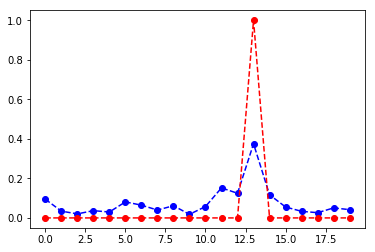

Epoch:5600, Loss: 0.14141850173473358
[0.2638722360134125, 0.4785081744194031, 0.17777729034423828, 0.6654910445213318, 0.9355664849281311, 0.973215639591217, 0.6661116480827332, 0.5474507212638855, 0.32191553711891174, 0.6916606426239014]


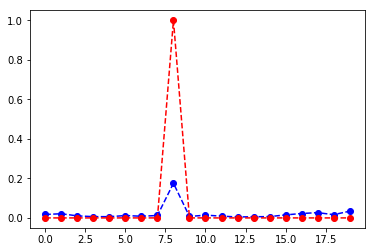

Epoch:5700, Loss: 0.12727293372154236
[0.1562620848417282, 0.17325706779956818, 0.1600821167230606, 0.5645391345024109, 0.9301264882087708, 0.9774208664894104, 0.9929118752479553, 0.9530690908432007, 0.7780783772468567, 0.5845069885253906]


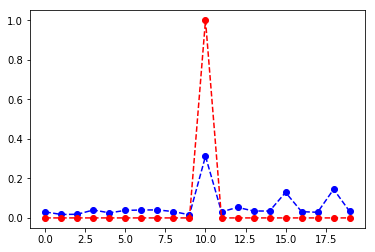

Epoch:5800, Loss: 0.1071755588054657
[0.2078469693660736, 0.20801307260990143, 0.35334670543670654, 0.9660321474075317, 0.766024649143219, 0.1880452036857605, 0.34881043434143066, 0.9495071768760681, 0.8348634839057922, 0.9685814380645752]


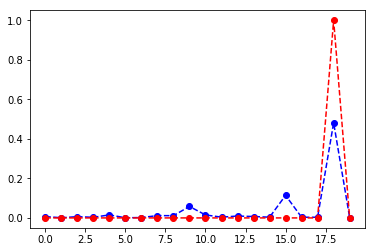

Epoch:5900, Loss: 0.10646592080593109
[0.1795470118522644, 0.18442721664905548, 0.18697260320186615, 0.1823541820049286, 0.9796106815338135, 0.9830405116081238, 0.8360426425933838, 0.16641423106193542, 0.11021342128515244, 0.10773149132728577]


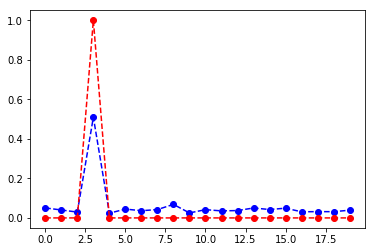

Epoch:6000, Loss: 0.1343628317117691
[0.16680316627025604, 0.17031694948673248, 0.16407683491706848, 0.17427097260951996, 0.16804055869579315, 0.17056159675121307, 0.16571569442749023, 0.172173410654068, 0.16675017774105072, 0.16365563869476318]


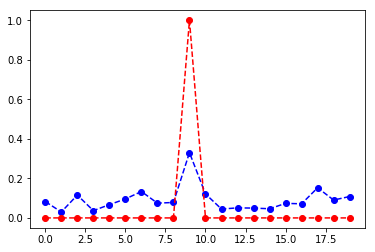

Epoch:6100, Loss: 0.09060731530189514
[0.9850289225578308, 0.978917121887207, 0.9401335716247559, 0.9824091196060181, 0.9803167581558228, 0.9830926656723022, 0.9997569918632507, 0.9907830953598022, 0.9681494235992432, 0.9245461821556091]


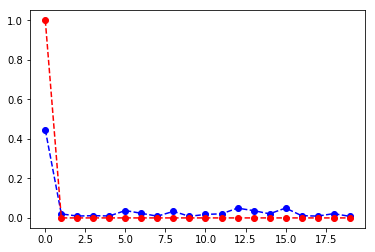

Epoch:6200, Loss: 0.12193505465984344
[0.998977780342102, 0.9831357598304749, 0.8161724805831909, 0.9165963530540466, 0.44971394538879395, 0.6142916083335876, 0.7432215809822083, 0.40856027603149414, 0.4588509202003479, 0.8609764575958252]


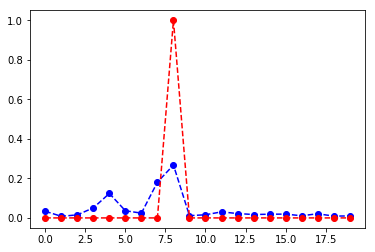

Epoch:6300, Loss: 0.10085888206958771
[0.9802315831184387, 0.9945017099380493, 0.9986191987991333, 0.9881700277328491, 0.9901651740074158, 0.9942423701286316, 0.991329550743103, 0.8926042318344116, 0.9660082459449768, 0.9839093089103699]


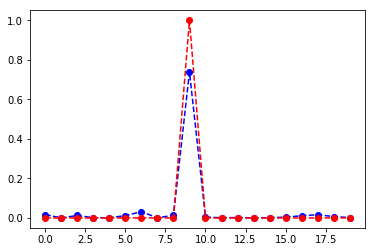

Epoch:6400, Loss: 0.13378797471523285
[0.9996641874313354, 0.9999109506607056, 0.9998902082443237, 0.9999692440032959, 0.9999871253967285, 0.9999874830245972, 0.999997615814209, 0.9999725818634033, 0.9998704195022583, 0.9958706498146057]


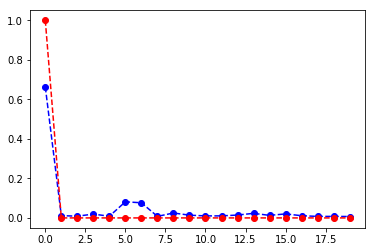

Epoch:6500, Loss: 0.12282013893127441
[0.2789929509162903, 0.9989320635795593, 0.9983230233192444, 0.9985791444778442, 0.9978583455085754, 0.5336161255836487, 0.9777968525886536, 0.989398717880249, 0.9863522052764893, 0.9999428987503052]


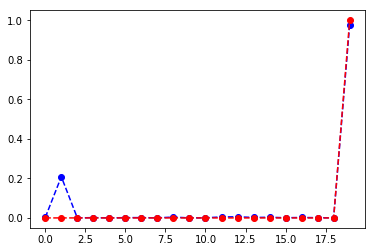

Epoch:6600, Loss: 0.11927802115678787
[0.7797434329986572, 0.7669721245765686, 0.8099321126937866, 0.6477715373039246, 0.6186686158180237, 0.5134073495864868, 0.5314885973930359, 0.7019259929656982, 0.8908635377883911, 0.8227908611297607]


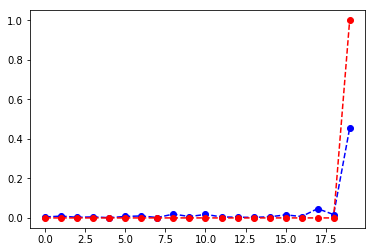

Epoch:6700, Loss: 0.10983579605817795
[0.10683164745569229, 0.10923390090465546, 0.11642713844776154, 0.12351436913013458, 0.13264279067516327, 0.12677599489688873, 0.14786481857299805, 0.3955722451210022, 0.7845379710197449, 0.8164495229721069]


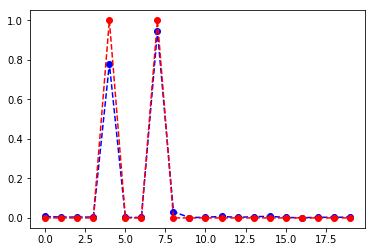

Epoch:6800, Loss: 0.13345617055892944
[0.9401420950889587, 0.513644814491272, 0.8136764764785767, 0.9707102179527283, 0.9544516801834106, 0.9062301516532898, 0.8057011961936951, 0.871924877166748, 0.898356556892395, 0.9772232174873352]


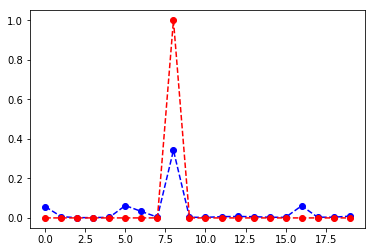

Epoch:6900, Loss: 0.12494812905788422
[0.9872890710830688, 0.9796446561813354, 0.9392938613891602, 0.984779953956604, 0.9810619950294495, 0.9855344295501709, 0.9998669624328613, 0.991675615310669, 0.9724407196044922, 0.9286636710166931]


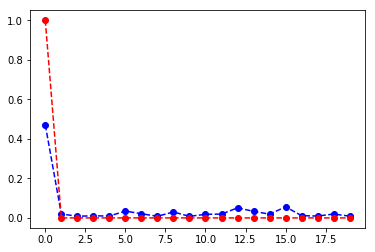

Epoch:7000, Loss: 0.1139526292681694
[0.1940065622329712, 0.5622877478599548, 0.5145490169525146, 0.6120817065238953, 0.6476186513900757, 0.7713037133216858, 0.8129939436912537, 0.5717083215713501, 0.5946140289306641, 0.255528062582016]


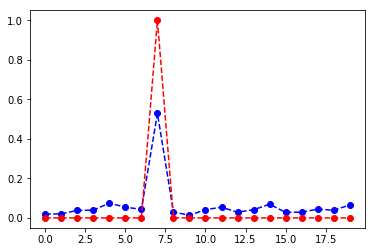

Epoch:7100, Loss: 0.12529036402702332
[0.9960297346115112, 0.30464163422584534, 0.999472439289093, 0.9789862036705017, 0.9863160252571106, 0.9891487956047058, 0.9893997311592102, 0.967864990234375, 0.9624674320220947, 0.9386343359947205]


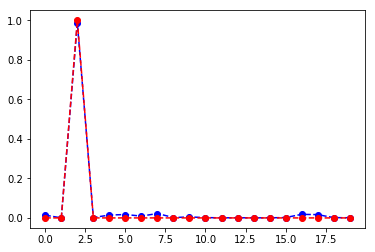

Epoch:7200, Loss: 0.09940382838249207
[0.6682144403457642, 0.9221683740615845, 0.9714038968086243, 0.3794839084148407, 0.2867468297481537, 0.08123697340488434, 0.09054394066333771, 0.10481756925582886, 0.15745528042316437, 0.09093882888555527]


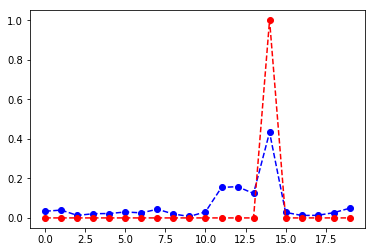

Epoch:7300, Loss: 0.13256202638149261
[0.18659232556819916, 0.20035964250564575, 0.09215392172336578, 0.767091691493988, 0.9216639995574951, 0.8957444429397583, 0.873476505279541, 0.9839653968811035, 0.7070564031600952, 0.9904983639717102]


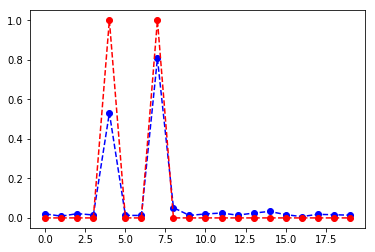

Epoch:7400, Loss: 0.1378929167985916
[0.08469200134277344, 0.09121505916118622, 0.09547435492277145, 0.08073893189430237, 0.10192796587944031, 0.09844280034303665, 0.0966777428984642, 0.10401949286460876, 0.0950777530670166, 0.1428108811378479]


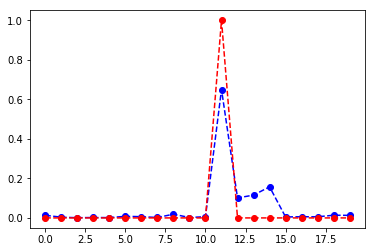

Epoch:7500, Loss: 0.11136271059513092
[0.16420109570026398, 0.10430657118558884, 0.10479652136564255, 0.15945439040660858, 0.13336554169654846, 0.17628075182437897, 0.10418381541967392, 0.09660614281892776, 0.07268168777227402, 0.10115619003772736]


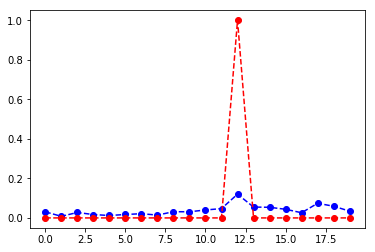

Epoch:7600, Loss: 0.11293510347604752
[0.09860701858997345, 0.08595187216997147, 0.11685992032289505, 0.10944347828626633, 0.11524467170238495, 0.10419966280460358, 0.08581587672233582, 0.20044107735157013, 0.7800750732421875, 0.4877018332481384]


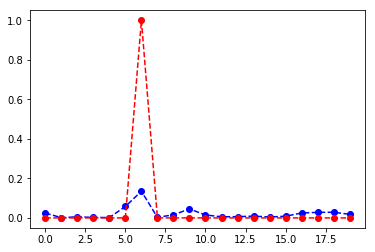

Epoch:7700, Loss: 0.10585075616836548
[0.9956947565078735, 0.9837139844894409, 0.9949900507926941, 0.9999622106552124, 0.999667763710022, 0.9999814033508301, 0.9994352459907532, 0.9985114932060242, 0.9977466464042664, 0.9995461106300354]


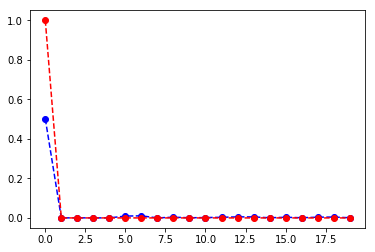

Epoch:7800, Loss: 0.1050589382648468
[0.1151280328631401, 0.08582522720098495, 0.2015082687139511, 0.2612869441509247, 0.9363744854927063, 0.22990302741527557, 0.7702386379241943, 0.08803282678127289, 0.3831784129142761, 0.0897035002708435]


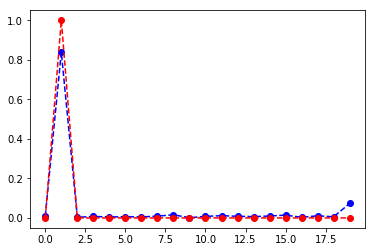

Epoch:7900, Loss: 0.10825949907302856
[0.1116572692990303, 0.09830733388662338, 0.09935012459754944, 0.07575409859418869, 0.08087746053934097, 0.08373674750328064, 0.3583605885505676, 0.652224063873291, 0.6673158407211304, 0.6397127509117126]


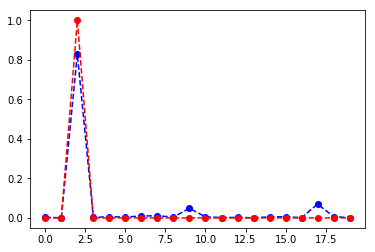

Epoch:8000, Loss: 0.09226153790950775
[0.15857672691345215, 0.1611090451478958, 0.336433082818985, 0.2389584630727768, 0.48420268297195435, 0.4159749746322632, 0.4744753837585449, 0.9868693947792053, 0.11422518640756607, 0.08524856716394424]


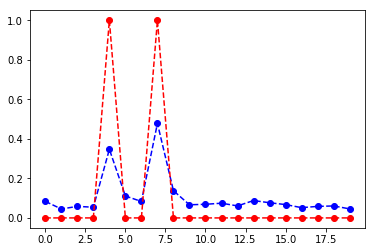

Epoch:8100, Loss: 0.11065547168254852
[0.5282888412475586, 0.4719792604446411, 0.3554787337779999, 0.2832479774951935, 0.15345264971256256, 0.38543567061424255, 0.16991358995437622, 0.28081604838371277, 0.9999992847442627, 0.9999382495880127]


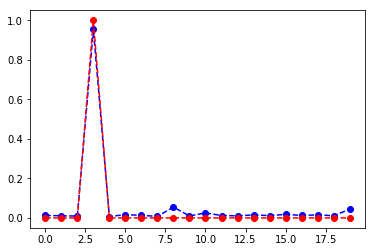

Epoch:8200, Loss: 0.11683613061904907
[0.884027361869812, 0.9911198019981384, 0.9922500848770142, 0.9078252911567688, 0.9846580028533936, 0.9913853406906128, 0.9708941578865051, 0.9988799691200256, 0.028498027473688126, 0.04538175091147423]


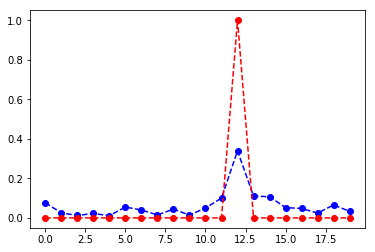

Epoch:8300, Loss: 0.1066538393497467
[0.2347303181886673, 0.25626340508461, 0.5434380769729614, 0.17666448652744293, 0.2400370091199875, 0.39149150252342224, 0.4208435118198395, 0.5836347937583923, 0.42796289920806885, 0.5167933702468872]


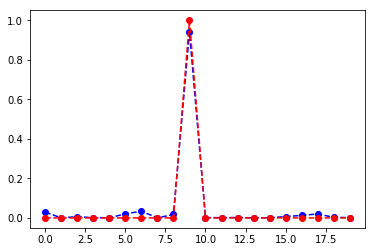

Epoch:8400, Loss: 0.0871443897485733
[0.5712560415267944, 0.7839260697364807, 0.9877311587333679, 0.9493241310119629, 0.9888048768043518, 0.9993094205856323, 0.9999151229858398, 0.9992477893829346, 0.951734721660614, 0.961083173751831]


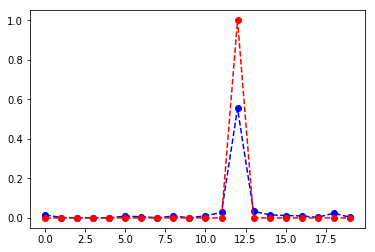

Epoch:8500, Loss: 0.10960178822278976
[0.09783495217561722, 0.13149817287921906, 0.7112809419631958, 0.794243335723877, 0.178893581032753, 0.4563977122306824, 0.33232399821281433, 0.5130159854888916, 0.5204136371612549, 0.04582381993532181]


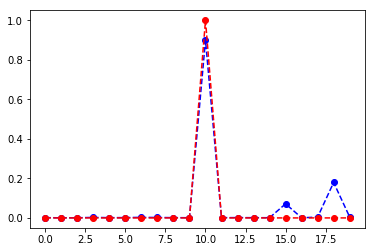

Epoch:8600, Loss: 0.10382150858640671
[0.9939391613006592, 0.9993383288383484, 0.9997541308403015, 0.9995284080505371, 0.9989882111549377, 0.961898684501648, 0.9329375624656677, 0.9372987151145935, 0.9557526707649231, 0.9406543970108032]


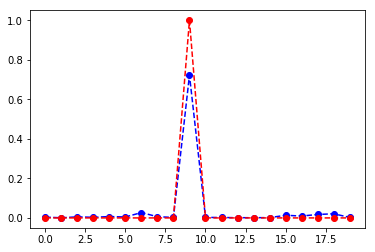

Epoch:8700, Loss: 0.11664879322052002
[0.1013268381357193, 0.08934162557125092, 0.0907401442527771, 0.09199787676334381, 0.5487135648727417, 0.28039616346359253, 0.18623852729797363, 0.4199428856372833, 0.7704665064811707, 0.5406323075294495]


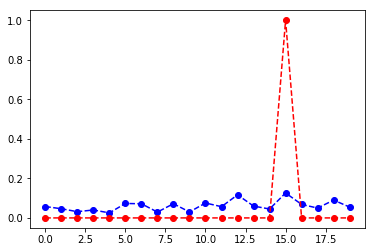

Epoch:8800, Loss: 0.09814025461673737
[0.9999839067459106, 0.9996685981750488, 0.9996477365493774, 0.9980424642562866, 0.9995416402816772, 0.9998237490653992, 0.9991492033004761, 0.9996730089187622, 0.9999785423278809, 0.9999898672103882]


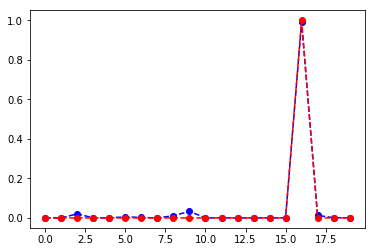

Epoch:8900, Loss: 0.11719111353158951
[0.09761244058609009, 0.08573020249605179, 0.08703427016735077, 0.08829450607299805, 0.546540379524231, 0.2769608795642853, 0.1823972463607788, 0.42232194542884827, 0.7649263143539429, 0.5376092791557312]


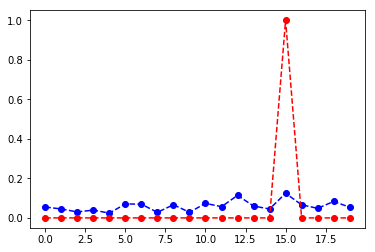

Epoch:9000, Loss: 0.10450021922588348
[0.7192542552947998, 0.6989482641220093, 0.751961886882782, 0.481044739484787, 0.48086073994636536, 0.29971450567245483, 0.32832565903663635, 0.5390077233314514, 0.8778988718986511, 0.7723879814147949]


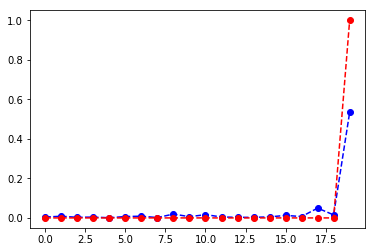

Epoch:9100, Loss: 0.11201992630958557
[0.07715027034282684, 0.07899576425552368, 0.07748532295227051, 0.0778236910700798, 0.9397111535072327, 0.9998382329940796, 0.9999634027481079, 0.9939139485359192, 0.9999209642410278, 0.9513663649559021]


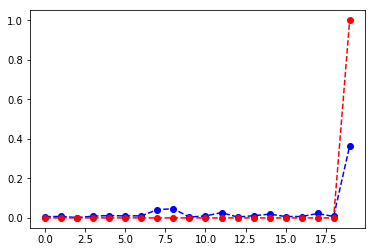

Epoch:9200, Loss: 0.09527131915092468
[0.6834235191345215, 0.9975298047065735, 0.9968146681785583, 0.942591667175293, 0.9973517656326294, 0.9998660087585449, 0.999344527721405, 0.9996792078018188, 0.9980027079582214, 0.9985639452934265]


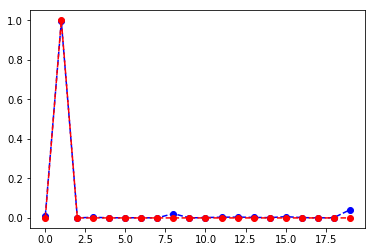

Epoch:9300, Loss: 0.0789109393954277
[0.10190608352422714, 0.9874352216720581, 0.9984286427497864, 0.9934380650520325, 0.9996988773345947, 0.9854781627655029, 0.9992788434028625, 0.9996453523635864, 0.9997279047966003, 0.9987494945526123]


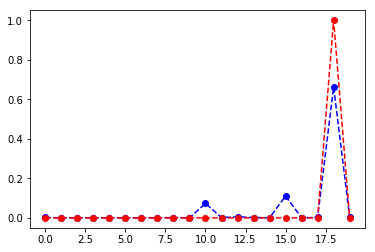

Epoch:9400, Loss: 0.09375885128974915
[0.5351593494415283, 0.8414879441261292, 0.9179649353027344, 0.8525840640068054, 0.8879755139350891, 0.9222838878631592, 0.9065138101577759, 0.6131097674369812, 0.8566269278526306, 0.8620741367340088]


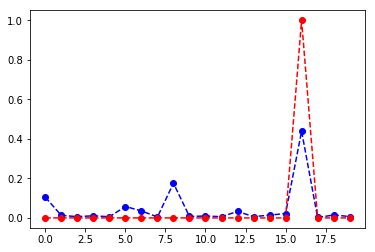

Epoch:9500, Loss: 0.11467543244361877
[0.39441588521003723, 0.14867174625396729, 0.6510069370269775, 0.23927149176597595, 0.13522447645664215, 0.8725355267524719, 0.584446370601654, 0.8691030740737915, 0.9524391889572144, 0.8113136291503906]


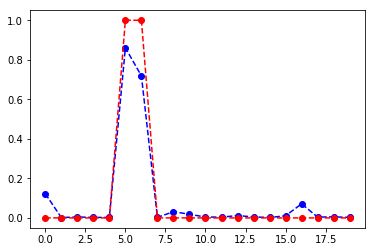

Epoch:9600, Loss: 0.0946345180273056
[0.11637748032808304, 0.8137479424476624, 0.9158633947372437, 0.9737995266914368, 0.9179691672325134, 0.5992942452430725, 0.45898759365081787, 0.7940291166305542, 0.5756769776344299, 0.8536070585250854]


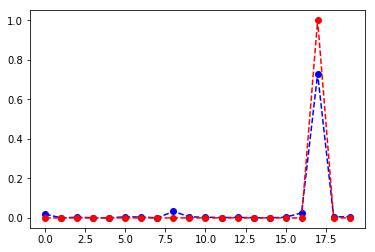

Epoch:9700, Loss: 0.10027025640010834
[0.05799590051174164, 0.061025895178318024, 0.05834907665848732, 0.2012048214673996, 0.506159245967865, 0.9403344392776489, 0.7858054041862488, 0.9889463782310486, 0.9832065105438232, 0.9033477306365967]


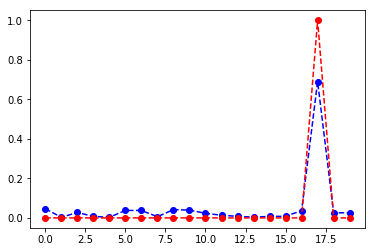

Epoch:9800, Loss: 0.0957329273223877
[0.05583784729242325, 0.05470407381653786, 0.3149593472480774, 0.8208754062652588, 0.5213003158569336, 0.8444215655326843, 0.3519883155822754, 0.9254373908042908, 0.7705768942832947, 0.8212258815765381]


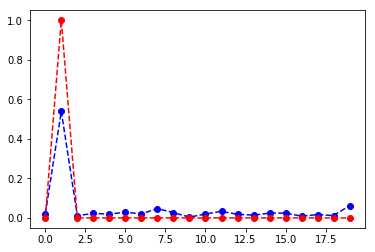

Epoch:9900, Loss: 0.1235792487859726
[0.027323290705680847, 0.034644145518541336, 0.03596216440200806, 0.037865497171878815, 0.03622196987271309, 0.021358365193009377, 0.0338517390191555, 0.02924094907939434, 0.03173035755753517, 0.030967220664024353]


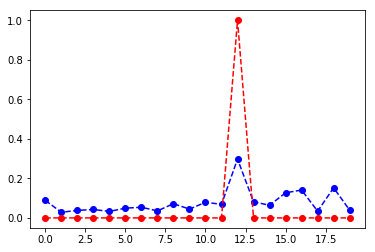

Epoch:10000, Loss: 0.1124832034111023
[0.037942610681056976, 0.21677541732788086, 0.10577429085969925, 0.12938806414604187, 0.6168767213821411, 0.645560085773468, 0.898222029209137, 0.9971031546592712, 0.9926290512084961, 0.9991886019706726]


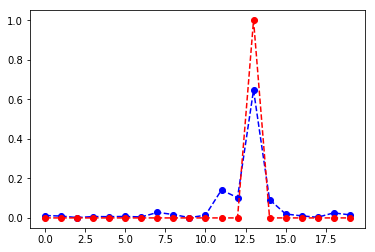

Epoch:10100, Loss: 0.10252052545547485
[0.941688597202301, 0.9995632767677307, 0.9984192848205566, 0.0382649265229702, 0.24269697070121765, 0.18180344998836517, 0.4357975125312805, 0.9926108717918396, 0.9999793767929077, 0.9992920160293579]


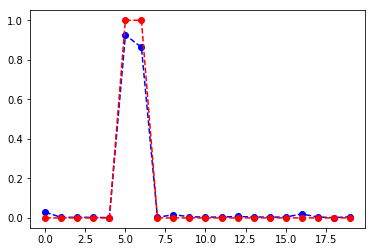

Epoch:10200, Loss: 0.08558036386966705
[0.05995449051260948, 0.06477977335453033, 0.0944725051522255, 0.09316136687994003, 0.10466504096984863, 0.09356815367937088, 0.3318074941635132, 0.9715320467948914, 0.9868641495704651, 0.9324051141738892]


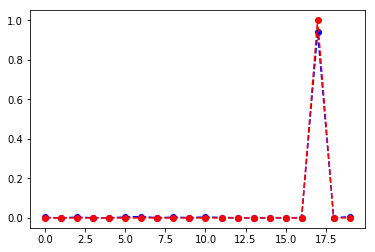

Epoch:10300, Loss: 0.1068858951330185
[0.050296105444431305, 0.047937650233507156, 0.3062628507614136, 0.7913534641265869, 0.45604804158210754, 0.8114885091781616, 0.2896714508533478, 0.9087879657745361, 0.7229546904563904, 0.7792810201644897]


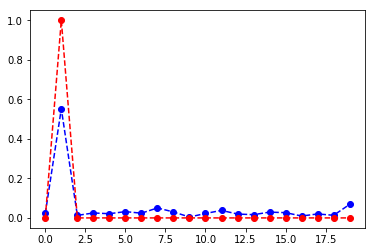

Epoch:10400, Loss: 0.08815943449735641
[0.9771732091903687, 0.9899389743804932, 0.9967819452285767, 0.9999985694885254, 0.7556357383728027, 0.8629686832427979, 0.9898521304130554, 0.3625010550022125, 0.9534058570861816, 0.8325591683387756]


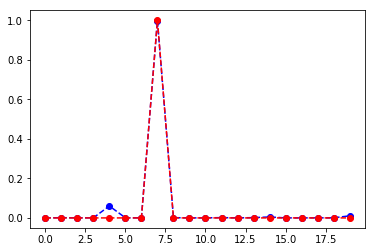

Epoch:10500, Loss: 0.09825430810451508
[0.7211325764656067, 0.9432024955749512, 0.881156861782074, 0.971070408821106, 0.9874366521835327, 0.999625563621521, 0.9996799230575562, 0.586731493473053, 0.031891971826553345, 0.19640487432479858]


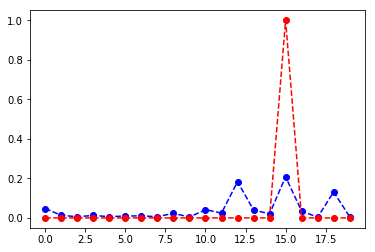

Epoch:10600, Loss: 0.1119760274887085
[0.0358516164124012, 0.2555527091026306, 0.03906596451997757, 0.04319135472178459, 0.030510444194078445, 0.04273408651351929, 0.6860009431838989, 0.28518983721733093, 0.037306495010852814, 0.055672574788331985]


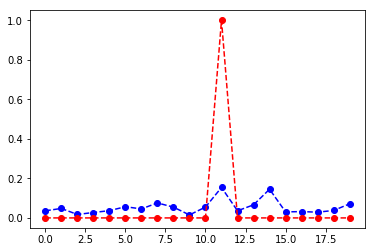

Epoch:10700, Loss: 0.11334925889968872
[0.6297541260719299, 0.9981938004493713, 0.9973579049110413, 0.941862940788269, 0.9978893399238586, 0.9998863935470581, 0.9993330836296082, 0.999765932559967, 0.998458743095398, 0.9988487958908081]


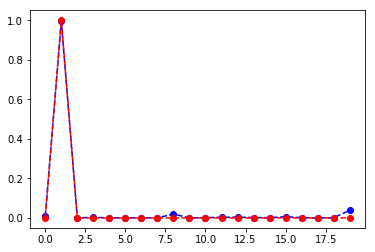

Epoch:10800, Loss: 0.09132230281829834
[0.02390027977526188, 0.01900382712483406, 0.7381553649902344, 0.9989676475524902, 0.9248364567756653, 0.06235146149992943, 0.9415442943572998, 0.999758780002594, 0.9999454021453857, 0.9999150037765503]


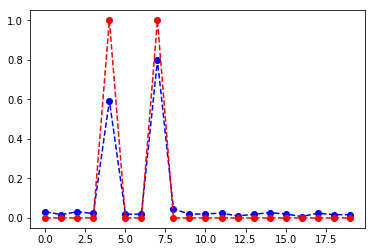

Epoch:10900, Loss: 0.11329343169927597
[0.9615100622177124, 0.9983568787574768, 0.9930680990219116, 0.9869009852409363, 0.24510566890239716, 0.6822420358657837, 0.9899221062660217, 0.7524529695510864, 0.6289806962013245, 0.4964141547679901]


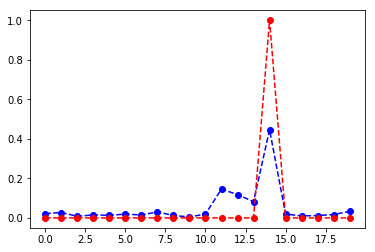

Epoch:11000, Loss: 0.10933760553598404
[0.2988056540489197, 0.02788272686302662, 0.07981197535991669, 0.28779736161231995, 0.5691795349121094, 0.6525887250900269, 0.24564319849014282, 0.13477225601673126, 0.09943758696317673, 0.04854574427008629]


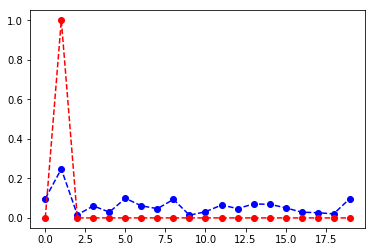

Epoch:11100, Loss: 0.09413164854049683
[0.08351463079452515, 0.48361045122146606, 0.4921462833881378, 0.5383243560791016, 0.47304636240005493, 0.7753252983093262, 0.8056734800338745, 0.5332257747650146, 0.5721973776817322, 0.1204080581665039]


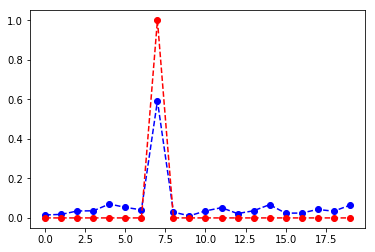

Epoch:11200, Loss: 0.10611258447170258
[0.9932627081871033, 0.999998927116394, 1.0, 0.9997736811637878, 0.9918604493141174, 0.9999997615814209, 0.566535472869873, 0.1299450546503067, 0.9936633110046387, 0.725716769695282]


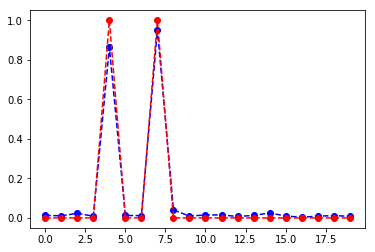

Epoch:11300, Loss: 0.11995849758386612
[0.06027781590819359, 0.05634329095482826, 0.0506780706346035, 0.050301093608140945, 0.04086991399526596, 0.04994082823395729, 0.049097660928964615, 0.10228633880615234, 0.05650530755519867, 0.09272848814725876]


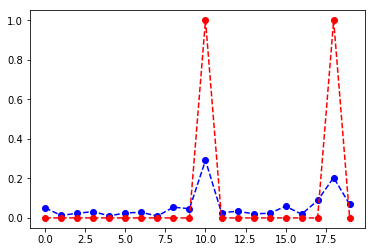

Epoch:11400, Loss: 0.09569519758224487
[0.13655413687229156, 0.04619073495268822, 0.6957913041114807, 0.991087019443512, 0.9858924746513367, 0.9509561061859131, 0.8533617854118347, 0.9012211561203003, 0.9824467897415161, 0.6576908230781555]


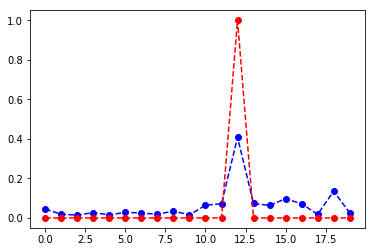

Epoch:11500, Loss: 0.11680321395397186
[0.996295154094696, 0.998755931854248, 0.9996036887168884, 0.9998273849487305, 0.9999765157699585, 0.9999994039535522, 0.9999980926513672, 0.9999996423721313, 0.9999310970306396, 0.999783456325531]


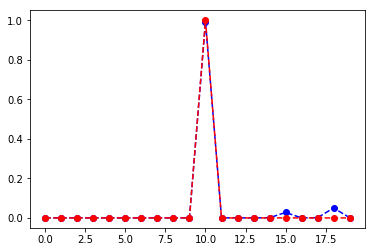

Epoch:11600, Loss: 0.08943600952625275
[0.48028433322906494, 0.13187450170516968, 0.4362089931964874, 0.3222818076610565, 0.024483492597937584, 0.07894578576087952, 0.07991181313991547, 0.050700295716524124, 0.16842596232891083, 0.15907761454582214]


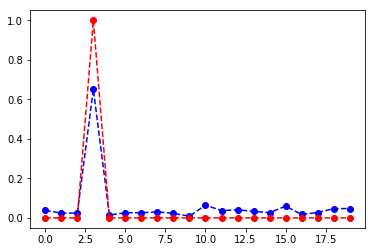

Epoch:11700, Loss: 0.11547169834375381
[0.7322039008140564, 0.3332329988479614, 0.7678848505020142, 0.6837595105171204, 0.8253549933433533, 0.6611976623535156, 0.8850225806236267, 0.8073644042015076, 0.28871577978134155, 0.6054580807685852]


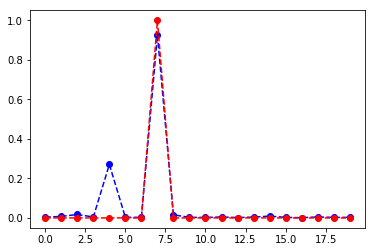

Epoch:11800, Loss: 0.1019207090139389
[0.9883635640144348, 0.9995014667510986, 0.9917667508125305, 0.9977425336837769, 0.9378905892372131, 0.9972871541976929, 0.7676884531974792, 0.8380855917930603, 0.7450343370437622, 0.9543635845184326]


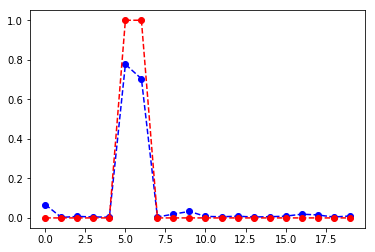

Epoch:11900, Loss: 0.11401286721229553
[0.05665583536028862, 0.052903007715940475, 0.04746221750974655, 0.04713072255253792, 0.038090165704488754, 0.04683144763112068, 0.04614561051130295, 0.1016044169664383, 0.05608313903212547, 0.09086448699235916]


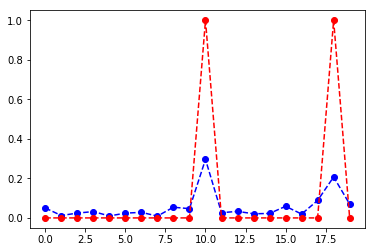

Epoch:12000, Loss: 0.10438361018896103
[0.9604753255844116, 0.8756071329116821, 0.99996018409729, 0.9845474362373352, 0.9754469990730286, 0.9958576560020447, 0.9897251129150391, 0.9706922769546509, 0.998193085193634, 0.9956367611885071]


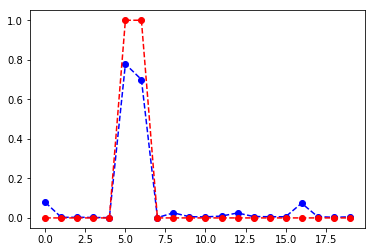

In [ ]:
from tensorboardX import SummaryWriter
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

writer = SummaryWriter()

for epoch in range(args.max_iter):
    # Randomly extract 10 video clips' I3D feature
    features, labels = thomoas_i3d_dataset.load_data(n_similar=args.num_similar)

    # Features are alingned in 750 frames all the same, now trunk it into max length
    seq_len = np.sum(np.max(np.abs(features), axis=2) > 0, axis=1)
    features = features[:,:np.max(seq_len),:]

    # Convert to CUDA tensor
    features = torch.from_numpy(features).float().to('cuda')
    labels = torch.from_numpy(labels).float().to('cuda')
    
    # Prediction and Loss
    attention_weights, weighted_features, output = model(features)
    
#     s_loss_value = softmax_loss(output, labels).detach().cpu().tolist()
    loss = softmax_loss(output, labels) + 0.00001*l1_norm(attention_weights)
#     loss = cross_loss(output, multi_to_single(labels).long())
    
    # Back Propogation
    optimizer.zero_grad() 
    loss.backward()  
    optimizer.step()
    
    # Testing performances
#     if epoch % 100 == 0:
        # Load test set and conduct validation
        
        
    # Save checkpoint
    if epoch % 5000 == 0 and epoch is not 0:
        # Reduce lr 
        lr /= 2
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        # Checkpoint structure
        model_state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        }

        torch.save(model_state, os.path.join(args.checkpoint_path, 'model_epoch_{:03}.pth'.format(epoch)))
    

    # Print out training loss
    loss_value = loss.detach().cpu().tolist()
    writer.add_scalar('runs/', loss_value, epoch)
    
    if epoch % 100 == 0:
        print('Epoch:{:03}, Loss: {:02}'.format(epoch, loss_value))

        print(attention_weights[0][0:10].tolist())
        plt.plot(output[0].tolist(), linestyle='--', marker='o', color='b')
        plt.plot(labels[0].tolist(), linestyle='--', marker='o', color='r')
        plt.show()

# export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")
writer.close()

# Load Pre-trained Model for testing


In [346]:
model = Attention_Module(feature_dim=2048)
checkpoint = torch.load('./checkpoint/model_epoch_5000_cross.pth')
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']
model.eval()
model.cuda()
print('model loaded')

model loaded


In [356]:
features, labels, _ = thomoas_i3d_dataset.load_data(n_similar=args.num_similar, is_training=False)
features = torch.from_numpy(features.reshape(1, -1, 2048)).cuda()
labels = torch.from_numpy(labels).cuda()

In [357]:
attention_weights, weighted_features, predict = model(features)